In [10]:
from ase.lattice.hexagonal import Graphene
from structures import  cut_rectangle,  show_atoms
import numpy  as np
import matplotlib.pyplot as plt

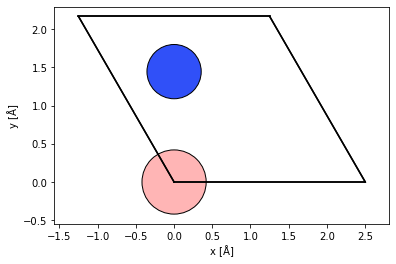

In [43]:
hbn_unit_cell = Graphene(symbol='N', latticeconstant={'a':2.502, 'c': 12})
hbn_unit_cell[0].symbol = 'B'
show_atoms(hbn_unit_cell);

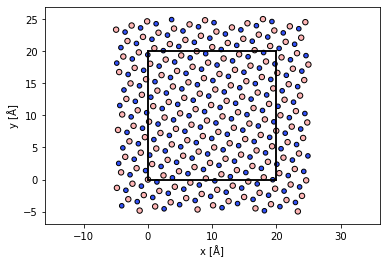

In [130]:
hbn = hbn_unit_cell.copy()
hbn.rotate(15, 'z',  rotate_cell=True)
hbn = cut_rectangle(hbn, (0,0), (20,20), margin=5)
show_atoms(hbn);

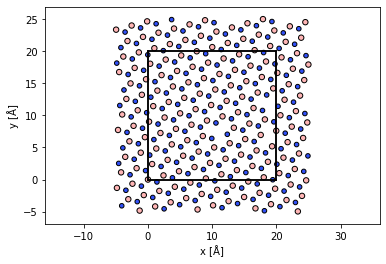

In [238]:
defect_hbn = hbn.copy()

num_b_vacancies = 2 #np.random.poisson(.5)
num_n_vacancies = 1 #np.random.poisson(.5)

inside = ((hbn.positions[:, 0] > 0) &
          (hbn.positions[:, 1] > 0) &
          (hbn.positions[:, 0] < hbn.cell[0,0]) &
          (hbn.positions[:, 1] < hbn.cell[1,1]))

b_inside = inside & (hbn.numbers == 5)
n_inside = inside & (hbn.numbers == 7)

to_delete = np.concatenate((np.random.choice(np.where(b_inside)[0], num_b_vacancies, replace=False),
                            np.random.choice(np.where(n_inside)[0], num_n_vacancies, replace=False)))

del defect_hbn[to_delete]

show_atoms(defect_hbn);

FWHM = 1.111 Å


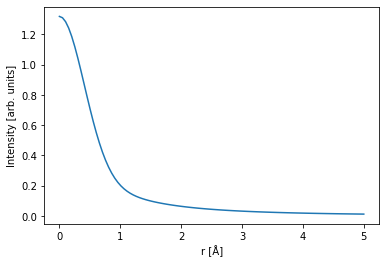

In [239]:
from scipy.interpolate import interp1d

gaussian = lambda x, sigma: np.exp(-x**2 / (2*sigma ** 2))
lorentz = lambda x, gamma: gamma / (np.pi * (x ** 2 + gamma ** 2)) 

x = np.linspace(0,5,100)
profile = gaussian(x, .4) + lorentz(x,1)

profile_interp = interp1d(x, profile, fill_value=0,  bounds_error=False)

plt.plot(x, profile)
plt.ylabel('Intensity [arb. units]')
plt.xlabel('r [Å]');

fwhm = x[np.argmin(np.abs(profile - profile[0] / 2))] * 2
print(f'FWHM = {fwhm:.3f} Å')

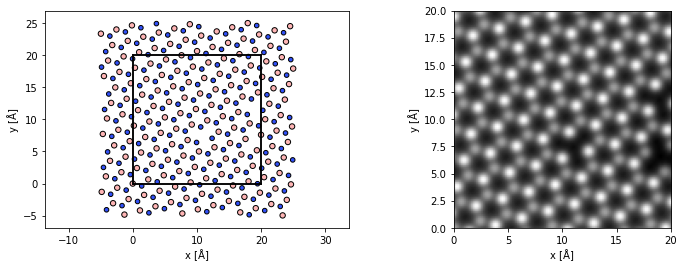

In [241]:
from simulator import simulate_2d_material

def show_image(image, ax=None):
    if ax is None:
        ax  = plt.subplot()
    
    imshow_kwargs = {'extent':[0, hbn.cell[0,0], 0, hbn.cell[1,1]], 'origin':'lower', 'cmap':'gray'}
    ax.imshow(image.T, **imshow_kwargs)
    ax.set_xlabel('x [Å]')
    ax.set_ylabel('y [Å]')

shape  = (128,128)
image = simulate_2d_material(defect_hbn, shape, profile_interp, 1.6)

fig,(ax1,ax2)=plt.subplots(1,2, figsize=(12,4))
show_atoms(defect_hbn, ax=ax1)
show_image(image, ax=ax2)

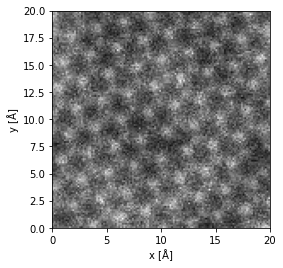

In [272]:
from scipy.ndimage import gaussian_filter

noisy_image = image.copy()

low_frequency_noise = gaussian_filter(np.random.randn(*image.shape), 10)
low_frequency_noise -= low_frequency_noise.min()

noisy_image += 90 * low_frequency_noise
noisy_image = np.random.poisson(noisy_image / 1.2).astype(np.float)

show_image(noisy_image)